In [16]:
%run ../Config/ImgConfig.ipynb
_ = HTML("""<style>.jp-OutputArea-output {display: table-cell;text-align: center !important;vertical-align: middle !important;}.jp-OutputArea-output img {width: 70% !important;}</style>""")

# 4. Data Collection and Pre-Processing

[index](../Index.ipynb) | [prev](./03.SystemDesign.ipynb) | [next](./05.Forecasting.ipynb)

The aim of the data collection pipeline is to use the Camera, to stream video signal to the central processing machine, which runs a series of operations to detect objects, and store images if objects of interest were identified.

This chapter is an in-depth analysis and an extension of a "Real time frames processing" diagram (Fig. 3.1.) from [Chapter 3](./03.SystemDesign.ipynb#fig3.5). The subject turned out to be quite complex, and I have broken it down into following sections:

- physical layer (hardware):
    - choosing hardware
    - connectivity
    - picking location for a camera
    - redundancy
- logical layer (software):
    - streaming video (called the client) and consuming video (called the server)
    - frame life-cycle (pre-processing image data, detecting motion and objects, forwarding video to other devices)
- results:
    - data representation
    - data volumes

## 4.1. Physical layer (hardware)

### 4.1.1. Choosing hardware

**Streaming device:**

Choosing the right hardware can be challenging and time consuming. When picking the camera system, there appears to be a two fundamentally different approaches to it:

- standalone (professional) camera unit
- mini computer with a camera module

My decision was motivated by the following factors:

- low cost
- popularity and online documentation
- flexibility in configuration
- ability to perform additional tasks on-device

Based on that I have decided that option 2 (mini computer) is a better choice. Raspberry Pi with an additional Pi-Camera module was my choice, due to my own experience with the device and high availability of online materials. Raspberry Pi specs:

- 4-core ARM processor
- 1GB of RAM
- Ethernet, 4 USB and HDMI ports

It carries enough processing power, considering the small form factor of $3.54 \times 2.36 \times 0.79$ inches.

The trade-off is that most of the standalone cameras are more durable and secure and often support Night Vision mode. All these extras come at much higher cost, little flexibility in terms of configuration options and limited online support.

**Processing device:**

For the server machine, I have decided to use a multi-purpose Desktop PC. In comparison with a popular, cloud option, I have identified two problems which cloud introduces:

- required fast and reliable broadband connection
- data goes outside of the local network and can be attacked by the hackers
- it introduces additional dependency and complexity

Below is the configuration for the PC:

- Intel i5 6-core CPU
- 32 GB RAM
- Nvidia GeForce 11 GB GPU
- Storage:
    - 256 GB NVME drive
    - 1 TB SSD drive

It allows to run a smooth, real time image preprocessing, object detection and scheduled tasks.

### 4.1.2. Connectivity

Initially I have set up the communication between devices as wireless, but it caused several issues. There was visible delay in the real time video stream, packets were dropping and logging in to Raspberry Pi remotely was very slow with occasional minutes of unresponsiveness.

I have chosen to wire the house, which allowed for near noiseless communication between the camera and the server, and sped up the development process significantly. The downside of this approach was that it was a timely and costly maneuver.

Below is a high level network topology diagram:

<p style="text-align: center; margin-bottom: 0;">Fig. 4.1. Network Topology</p>

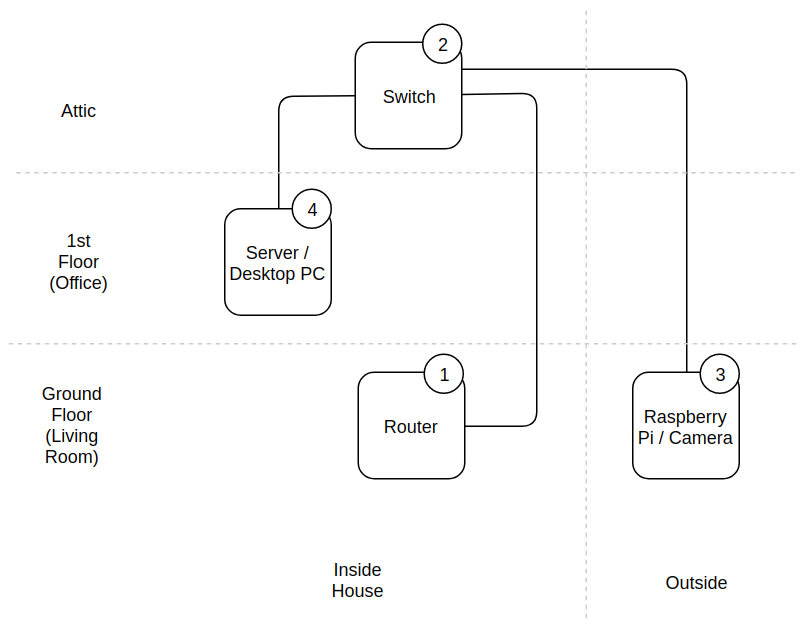

In [6]:
Image("../Resources/img/network-topology.png")

**Diagram Description**

In the diagram above, continuous lines represent wires, and dashed lines are either dividing floors, or the areas inside and outside the house:

- Starting from the router (1), signal goes to the attic to a 1Gb Switch (2), which has $4$ Power Over Ethernet (POE) ports
- From the switch, there is a network cable going into the Raspberry Pi (3), which is located outside of the house. Raspberry Pi has an additional POE module next to it, so it only requires a single wire to receive power and network. Pi does not support 1Gb connections through its native RJ45 port, but 100Mb is more than enough to transmit video signal at high rate
- The second connection from the switch goes down through the wall from attic into the office on the first floor, where the server PC (4) is located

Static IP addresses were assigned to the devices along with the hostnames, so they can be easily accessed from within the network.

### 4.1.3. Camera location

Optimal camera placement is not a trivial task.

I have decided to place a camera in a position, which is usually chosen as a primary security camera: in front of the house, above the main door. This decision was made after learnings from multiple experiments with other locations (for example inside the house, behind the window).

The location chosen for the camera is certainly too low to be considered a proper security camera, but it shelters the device against the rain, wind and direct sunlight, which are often a serious issue for the vision systems.

The RaspberryPi with camera module is glued using a strong double sided tape onto the roof in the porch:

<p style="text-align: center; margin-bottom: 0;">Fig. 4.1. Raspberry Pi Camera Placement #1</p>

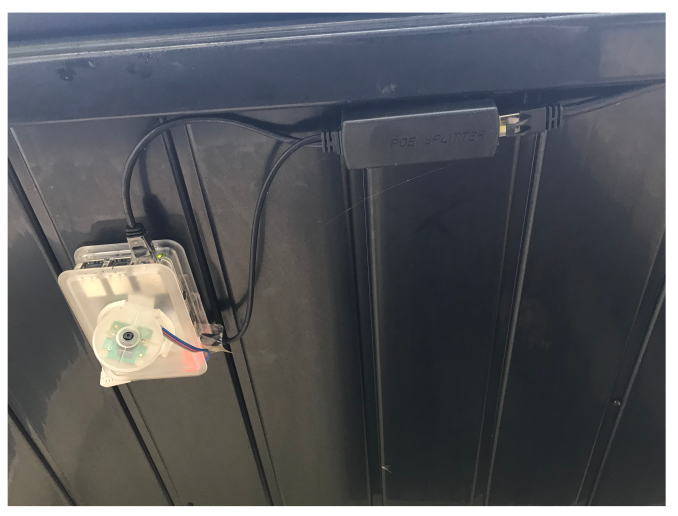

In [7]:
Image("../Resources/img/rpi-cam.png")

<p style="text-align: center; margin-bottom: 0;">Fig. 4.2. Raspberry Pi Camera Placement #2</p>

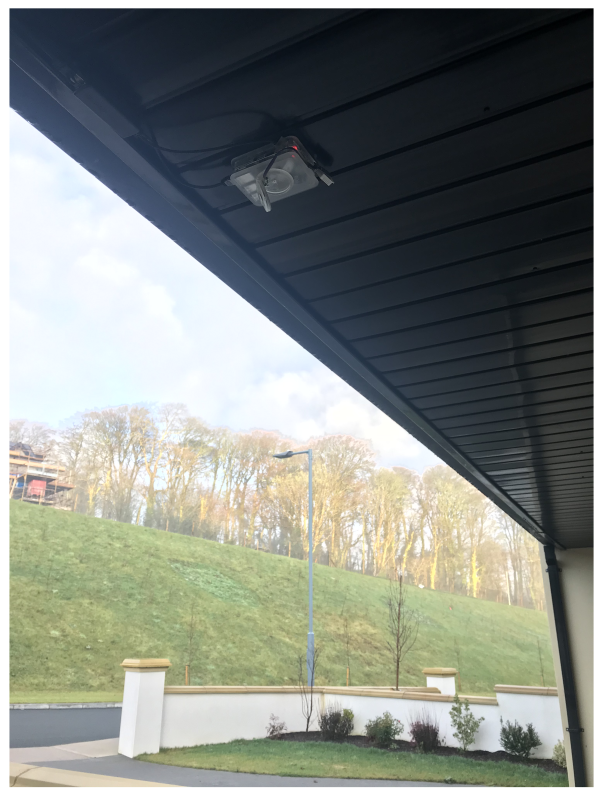

In [9]:
Image("../Resources/img/rpi-cam2.png")

After many attempts at getting a good and flexible case for Pi, I finally found one which allows for a full 360 camera rotation along both axis (this can be seen above in figures 4.1 and 4.2).

Surprisingly enough, even during harsh storm, wind and rain, the camera mount does not shift at all.

Another challenge, which can occur at random occasion is occlusion caused by a natural event. This could be as simple as a leaf or dust, but it can prevent camera from registering a clear picture for a long period of time. During the six months of data collection, only one such incident occurred when a spider decided to adopt the Raspberry Pi case as a house.

A good improvement for the future would be to detect the loss in image quality and send a maintenance alert to the users.

### 4.1.4. Redundancy

I have experienced three power outages, which meant a loss in data for three days (as I was at work during that time). Having an alternative source for the power is critical if the system must be always online. This redundancy comes at additional cost, and this is currently a limitation of this system.

What is also important is that when device comes online again, it should have a mechanism to resume streaming (or collecting) data. This will be discussed later in this chapter but is handled on both: client and server using an open source software called [Supervisor](http://supervisord.org/).

In case of hardware failures on the server, there is a back up script running every night to synchronize images into another machine. And in case of a hardware failure on the client, a spare Raspberry Pi exists (which is currently used as a test/development box).

## 4.2. Logical layer (software)

Below are the key software ingredients used in this project. Each of them already exists in a working system, but can also be further refined and improved from the innovation, scalability, reliability, security and performance point of view.

### 4.2.1. Video streams

There are many ways video frames can be broadcasted to other devices.

In general, people often choose easy to setup streaming protocols, like *RTSP* if they just want to display a video in a video player like VLC, however RTSP signal can be quite troublesome to capture if further image processing is required through Open CV and Python. Also, RTSP streams the video without considering if the receiving end is online.

If the audio component is not required and full flexibility and customization is important, then a message queue might be a better option. [ImageZMQ](https://github.com/jeffbass/imagezmq) is a convenient implementation of *ZMQ/PyZMQ* - a peer to peer message queue system optimized for high performance, with an option to receive acknowledgment signal from the receiving clients.

Here is a diagram of a frame exchange between Pi-camera and PC when *ImageZMQ* is used:

<p style="text-align: center; margin-bottom: 0;">Fig. 4.2. ZMQ Message Queue</p>

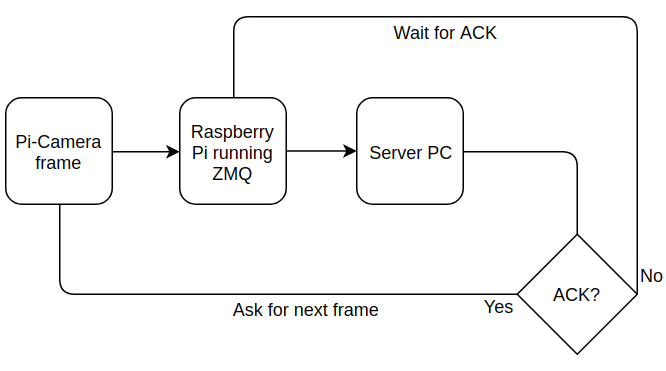

In [12]:
Image("../Resources/img/zmq.png")

In this type or architecture, there is no need to keep sending the frames when there is no-one receiving them as ACK signal is required before the next frame can be sent.

The drawback of this approach is that when receiver stops receiving, the streaming device sending script must be restarted (or connection re-initiated).

I have published two GitHub repositories with the code required to run a [client](https://github.com/Alchemication/iot-vstream-client), and a [server](https://github.com/Alchemication/iot-vstream-server).

The `client.py` and `server.py` scripts are registered in the Linux software called [Supervisor](http://supervisord.org/), which makes sure that the processes are always ON (when system restarts or when scripts get terminated for any reason).

### 4.2.2. Frame lifecycle (including object detection)

This is the most complex part of Data Collection. It took me over one year to get this end-to-end process right.

Below is a data flow for each frame:

<p style="text-align: center; margin-bottom: 0;">Fig. 4.3. Frame lifecycle</p>

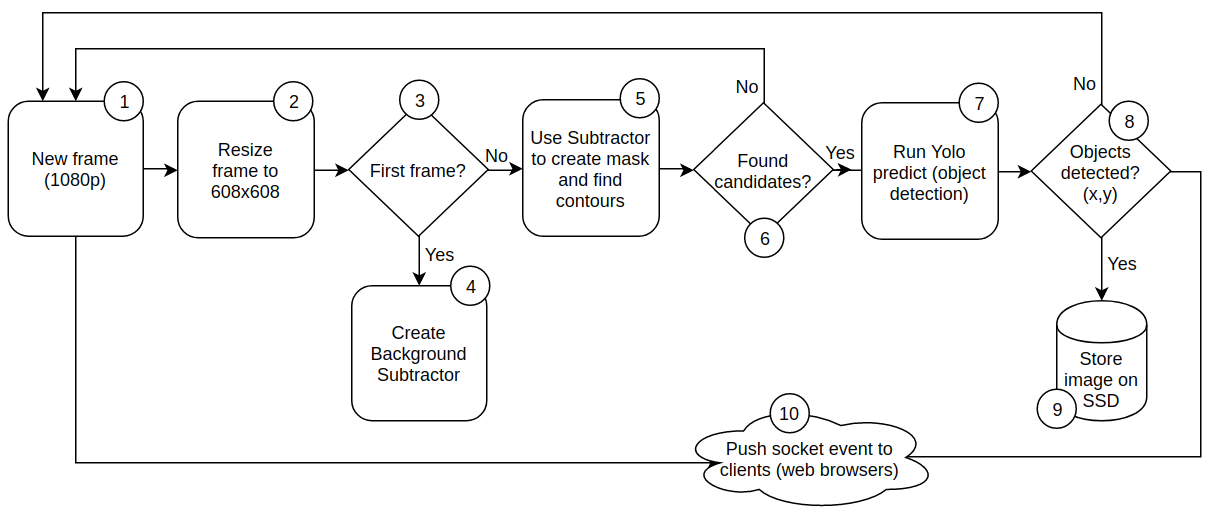

In [13]:
Image("../Resources/img/obj-detection.png")

**Diagram description**

Picking up from previous pseudo-code for capturing the stream (server):

- Once the frame is collected from the ImageHub, it is a full HD resolution: $1920\times1080$ px (1)
- The frame needs to be resized (2), otherwise next steps will be very slow. The choice of $608\times608$ makes sense, as this is a resolution needed by the Yolo algorithm (7)
- The next step is to use a static background to extract the moving foreground. This is a *Background Subtractor's* task (discussed in detail in the [Literature Review chaper](./02.LiteratureReview.ipynb))
- Before this technique can be applied, there is a check (3) if it has been already created
- Below are the arguments for the createBackgroundSubtractorMOG2 class described at [opencv website](https://docs.opencv.org/master/de/de1/group__video__motion.html#ga2beb2dee7a073809ccec60f145b6b29c):
    - `history` - Length of the history
    - `varThreshold` - Threshold on the squared Mahalanobis distance between the pixel and the model to decide whether a pixel is well described by the background model. This parameter does not affect the background update
    - `detectShadows` - If true, the algorithm will detect shadows and mark them. It decreases the speed a bit, so if you do not need this feature, set the parameter to false
    - *Mahalanobis distance* is a multivariate distance metric that measures the distance between a point and a distribution <cite data-cite="selva:2019:mahalonobis">(Prabhakaran, 2019)</cite> and unlike Euclidean distance, which measures distance between two points, is given by:
    $$
    D^2=(x-m)^T \cdot C^{-1} \cdot (x-m)
    $$
    , where $x$ is a vector of data points, $m$ is a vector of means for each feature, and $C^{-1}$ is an inverse covariance matrix of independent variable
    - The parameters above are mostly heuristics and they depend on the location of the camera, the size of the objects and the type of movement to detect. It usually helps to record multiple videos from a particular location for calibration purposes. Below are the values, which worked well in this scenario:
        - `BG_SUB_HISTORY = 20` - Use rolling $20$ images
        - `BG_SUB_THRESH = 30` - Ignore changes below threshold
        - `BG_SUB_SHADOWS = True` - Detect shadows
- The background subtraction algorithm is then applied (5) and the generated `mask` verified if the detected contours meet the criteria to become an object candidate
- According to my study, objects of size > $35$ are good candidates for further detection. Everything below this value is not a valid object and should be dropped. Parameter `MIN_OBJ_AREA` is another heuristic, which should be calibrated for each environment
- Once candidates are found, frame is forwarded to Object Detector (Yolo V2) to generate predictions for all objects in a [Coco dataset](https://cocodataset.org/#home) (like Person,Car,Dog,Bike etc.). This activity happens in step 7, while Yolo itself is instantiated before the main loop, using following parameters:
    - `THRESHOLD = 0.40` - Reject detections with confidence lower than $0.4$
    - `GPU = 0.5` - Use only $50\%$ of GPU for computation
- Yolo requires to provide the set of labels (yolov2.cfg), pre-trained weights (yolov2.weights), confidence threshold for predictions (reject below ($0.40$)) and optionally how much GPU power can be used by this process ($0.5$ runs smoothly on 11Gb GPU with $608\times608$ images). Predictions are generated with `tfnet.return_predict(frame)` code, which returns a list of objects, with the confidence and x,y coordinates
- Also within step 7, script needs to filter out all objects, which are not tracked (like lamp, monitor, phone etc.) and only then final predictions are obtained and can be checked (8)
- If an object of interest is detected, frame is saved as an image on the hard drive (9) in a folder corresponding to a date (along with the filename, representing time and name of all objects detected in a frame)
- Then, independently of the object detection process, the original $1080p$ frame, along with the predictions, are pushed through the socket server (10) to the outside world (a web application can connect to this socket and receive a real time stream with object detections)
- The values sent over socket will help to draw the bounding boxes around objects for any screen size (and multiple devices) in the UI layer.

## 4.3. Results

The result of the data collection are images with valid detections.

Image data is organized as a hierarchy of folders. The top level contains the streaming device name, which then contains directories corresponding to dates with image files inside. Image filenames contain objects detected and time.

<p style="text-align: center; margin-bottom: 0;">Fig. 4.4. Collected Images</p>

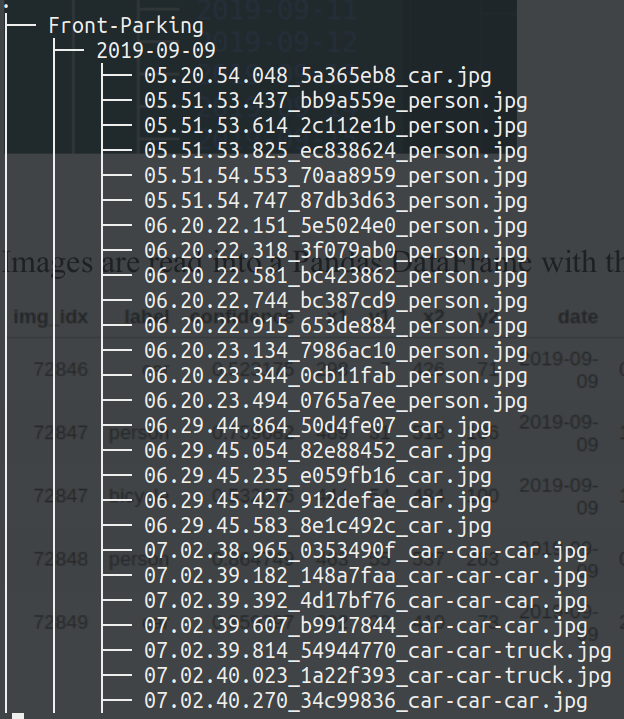

In [14]:
Image("../Resources/img/saves-files-tree.png")

The dataset collected for this research contains over $600K$ images between 09th of September 2019 and 02nd Match 2020. The size of a single $1080p$ image compressed to jpg is approx. $300kB$. The total size of the dataset is then approx. $180GB$.

An average number of raw images captured per day is approx. $2000$.

## 4.4. Conclusion

This Notebook presented a bird eye view over the valley of Data Collection. There are a lot of details, which have been omitted, like error handling, socket server implementation and running an infinite loop in a separate thread to capture the stream within a *Flask* app context. However all these nuggets can be found in the [Extra Script 1 - app.py](../Scripts/app.py), which was used to gather the dataset in this research.

Considering the amount of processing for each frame, this pipeline runs at impressive $30$ frames per second, and provides a smooth experience for the end users, who can observe real time object detections in a web browser.

There are a number of improvements already identified in this process, which are left for the future iterations:

- include *privacy mode*, where bounding boxes with detected people are blurred
- switch object detector to Yolo V4 for increased detection accuracy and speed
- test image segmentation techniques to improve the bounding boxes approach
- add hourly forecast of expected objects for a day into the UI
- trigger alerts when anomalies are detected:
    - number of objects in a current hour is suspiciously high
    - raw image content looks like it has come from a different population than the images registered in the history

[Next chapter](./05.Forecasting.ipynb) focuses on generating Forecast for the number of objects expected to appear in an hour.

[index](../Index.ipynb) | [prev](./03.SystemDesign.ipynb) | [next](./05.Forecasting.ipynb)